In [2]:
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)
# 测试模型训练的结果
import numpy as np
import torch
from brpnet.model import UNet
import matplotlib.pyplot as plt





In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3,1,1).to(device)
model.load_state_dict(torch.load('../train_model/segModel_800.pth'))


<All keys matched successfully>

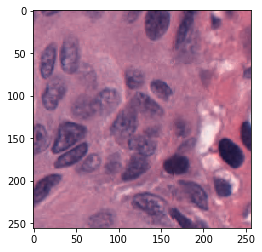

In [13]:
imgs = np.load('../dataset/trainDataSet.npy')
img = imgs[0]
img_copy = img.copy()
img_copy = img_copy[256:512,256:512]
plt.imshow(img_copy)



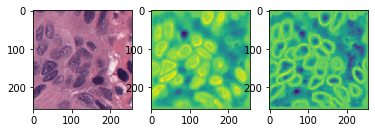

In [14]:
def infer(model,img):
    img_copy_copy = img.transpose(2,0,1)
    img_copy_copy = np.expand_dims(img_copy_copy,0)
    img_copy_copy = torch.tensor(img_copy_copy).float().to(device)
    sout, sout_0, sout_1, sout_2, sout_3, cout, cout_0, cout_1, cout_2, cout_3 = model(img_copy_copy)
    fig,ax = plt.subplots(1,3,figsize=(6,4))
    ax[0].imshow(img)
    ax[1].imshow(sout.cpu().data.numpy()[0][0])
    ax[2].imshow(cout.cpu().data.numpy()[0][0])
    return sout.cpu().data.numpy()[0][0], cout.cpu().data.numpy()[0][0]
    
sout, cout = infer(model,img_copy)

(128, 128, 3)


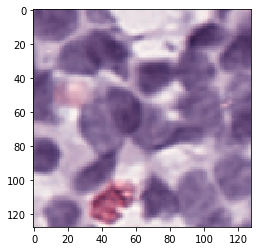

In [5]:
# 读取自己的文件
import cv2
from utils.ImageProcess.ImageProcess import normalizeStaining

selfImg = cv2.imread('slideImage00.png')
# 2000 4000
selfImg = cv2.cvtColor(selfImg,cv2.COLOR_BGR2RGB)
selfImgCrop = selfImg[1000:1128,1000:1128,:]
print(selfImgCrop.shape)
selfImgCrop_norm = normalizeStaining(selfImgCrop)
plt.imshow(selfImgCrop_norm[0])
plt.show()



(128, 128) (128, 128)


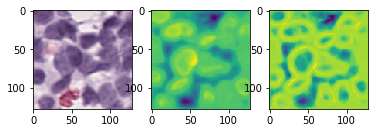

In [6]:
sout,cout = infer(model,selfImgCrop_norm[0])
print(sout.shape, cout.shape)

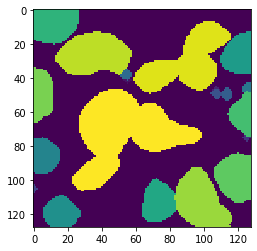

In [11]:
from skimage.morphology import label
from scipy import ndimage
import scipy.io as scio
from post_proc import post_proc

sout_copy = sout.copy()
cout_copy = cout.copy()

# fig,ax =plt.subplots(1,3,figsize=(6,4))
# sout_copy_proc = post_proc(sout_copy)
# cout_copy_proc = post_proc(cout_copy,cutoff=0,post_dilation_iter=0,post_fill_holes=False)
# ax[0].imshow(sout_copy)
# ax[1].imshow(sout_copy_proc)
# ax[2].imshow(cout_copy_proc)

output = post_proc(sout_copy-cout_copy,post_dilation_iter=2)
plt.imshow(output)
plt.show()





In [9]:

# sout_copy_proc2 = post_proc(sout_copy)
# cout_copy_proc2 = post_proc(cout_copy,cutoff=0.5,post_dilation_iter=0,post_fill_holes=False)
# ax[0].imshow(sout_copy)
# ax[1].imshow(sout_copy_proc2)
# ax[2].imshow(cout_copy_proc2)


In [21]:
'''
其他方面的一些测试
'''
import torch.nn.functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt

from postProcess.post_proc import post_proc
pred = np.load('val_pred/val_7_pred.npz')
sout = pred['sout']
cout = pred['cout']


print(sout.shape,cout.shape)

img_semantic = post_proc(sout,cutoff=0.5,post_dilation_iter=1)
img_outline = post_proc(cout,cutoff=0.5,post_dilation_iter=1,post_fill_holes=False)



(1000, 1000) (1000, 1000)


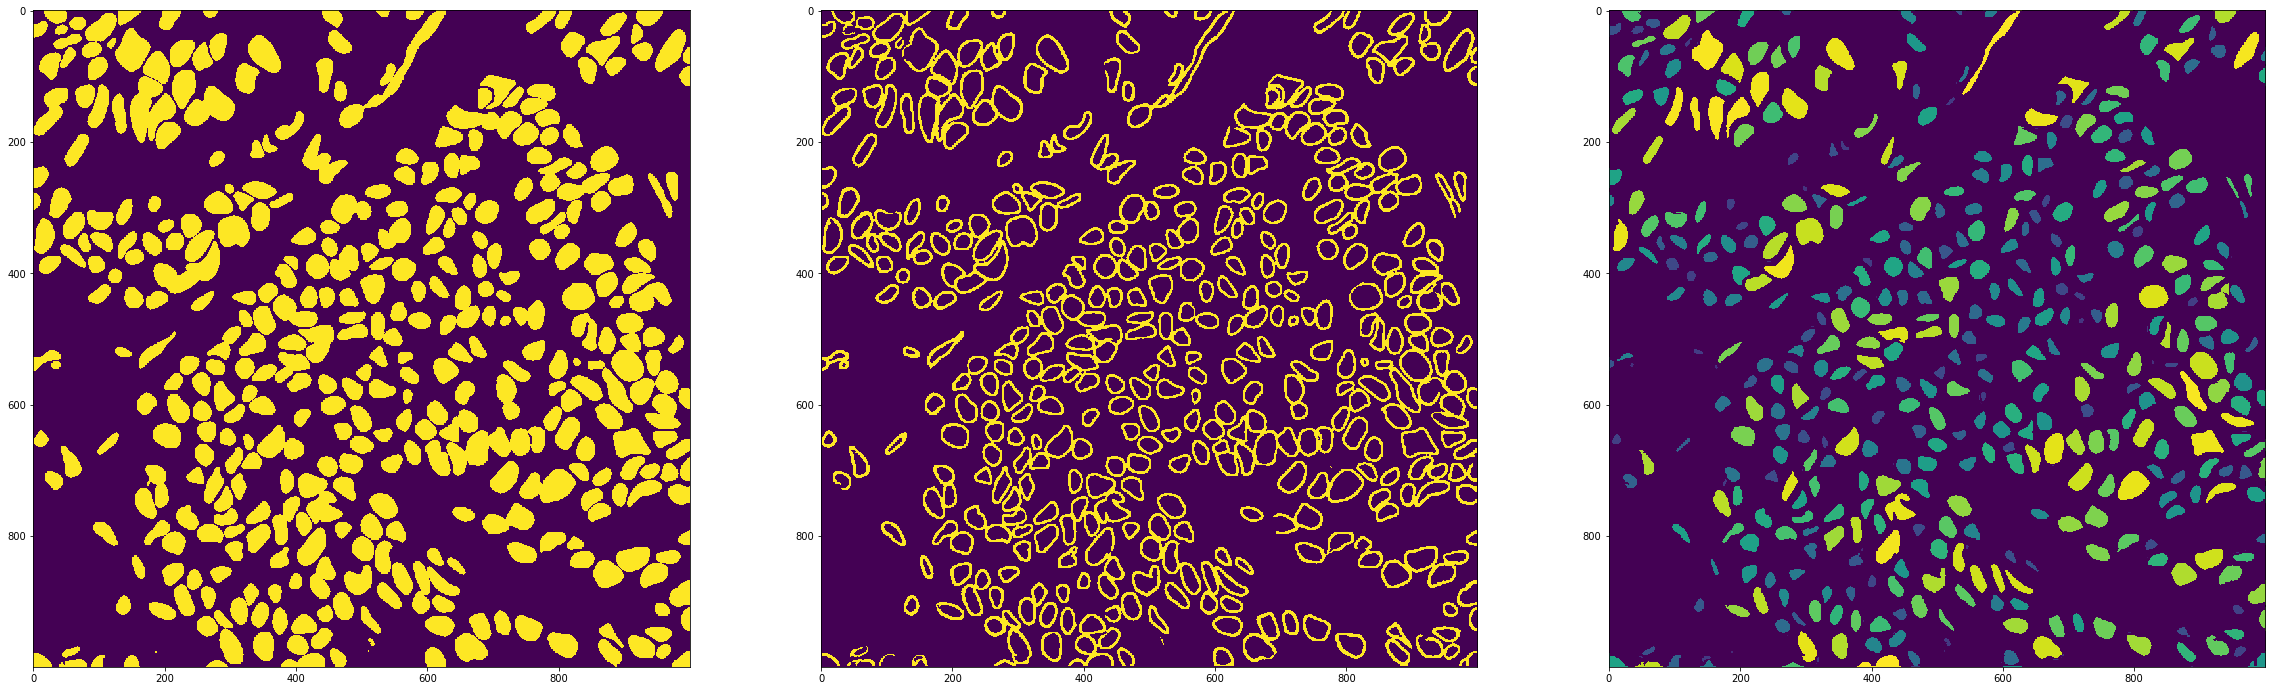

In [22]:
from scipy import ndimage

img_semantic[img_semantic != 0]=1
img_outline[img_outline != 0]=1

erosion_img = ndimage.morphology.binary_erosion(img_outline,iterations=1)

# 相减操作的时候不要进行膨胀操作
result = post_proc(img_semantic-erosion_img,post_dilation_iter=0)
fig,ax = plt.subplots(1,3,figsize=(40,40))

ax[0].imshow(img_semantic)
ax[1].imshow(erosion_img)
ax[2].imshow(result)
